In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

(879, 116)


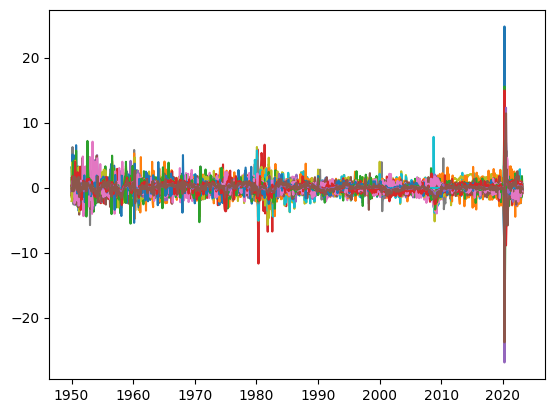

In [2]:

y, mask, index, columns= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

In [3]:
print(list(columns))
gdp_col = list(columns).index('GDPC1')

['PPIITM', 'PPICRM', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'IPMAN', 'MCUMFN', 'TCU', 'M0684AUSM343SNBR', 'M0504AUSM343SNBR', 'GDPC1', 'AMBSL', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'FEDFUNDS', 'CP3M', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXMMTH', 'EXSZUS', 'EXJPUS', 'EXUSUK', 'EXCAUS', 'PPIFGS', 'PPIFCG', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RETAIL', 'ACOGNO', 'ANDENO', 'AMDMUO', 'M1SL', 'M2SL', 'M3SL', 'M2REAL', 'RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'I

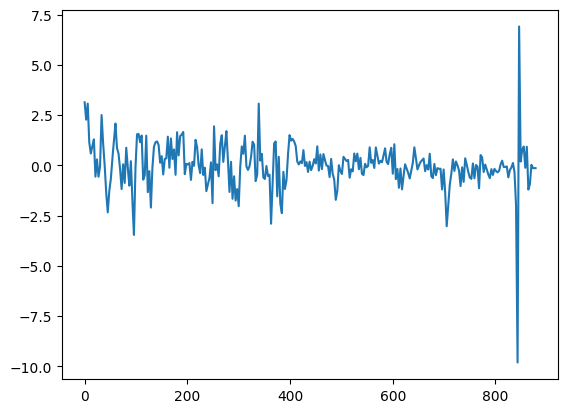

In [27]:
plt.plot(y[:,gdp_col])

(600, 116) (100, 116) (179, 116)


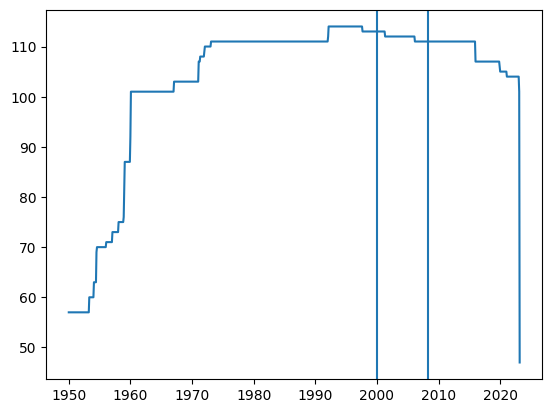

In [4]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 3
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25

#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [44]:

cfg.lr = 0.0003
cfg.max_iter = 200
cfg.n_epochs = 10
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Identity(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 815
torch.Size([600, 116]) torch.Size([100, 116])
1 14.51634156076531760765317
2 0.765104240492770604927706
3 0.650203077416670974166709
4 0.595214591214531412145314
5 0.544231949668181696681816
6 0.514004988105673581056735
7 0.4954023627858412778584127
8 0.4680585657295428572954284
9 0.4687319899860181998601813
10 0.467060749468050546805054
11 0.434113308003074240307424
12 0.421867220025313502531353
13 0.420824601462012846201284
14 0.427336997107455610745565
15 0.426723640216024321602436
16 0.412217993485300148530014
17 0.417253191533841653384165
18 0.402580756890146339014633
19 0.403755980102639470263947
20 0.404635493692598869259883
21 0.395638603913156691315666
22 0.396694973895424389542434
23 0.379305811304795130479517
24 0.379633570972241997224196
25 0.370232727966810596681055
26 0.375655651092529309252934
27 0.364530928825077262507726
28 0.364482973751268875126887
29 0.354396155006007130600713
30 0.348952832974885667488566
31 0.34117535384077774407

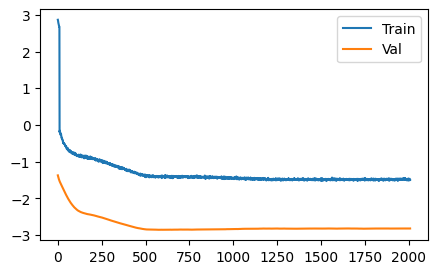

In [45]:
plot_train_hist(train_hist=train_hist, log=True)

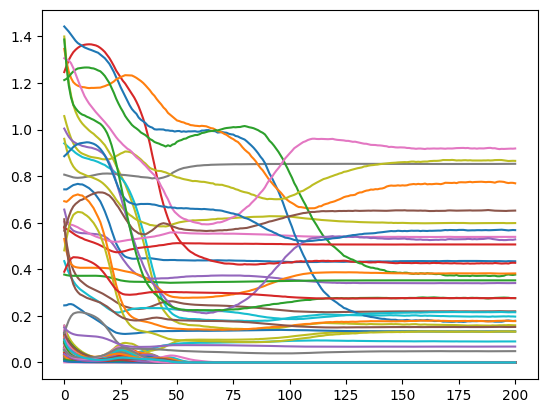

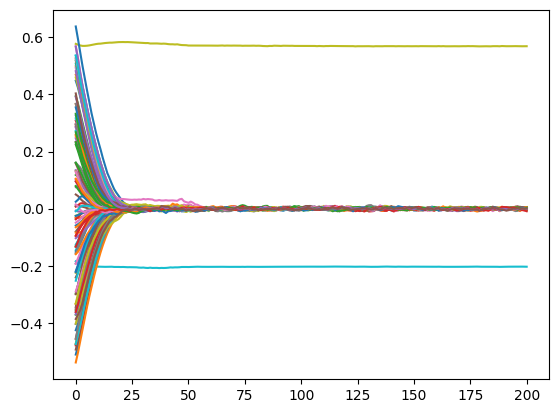

In [46]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


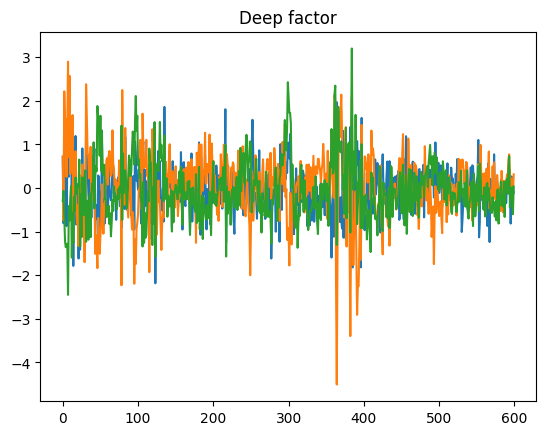

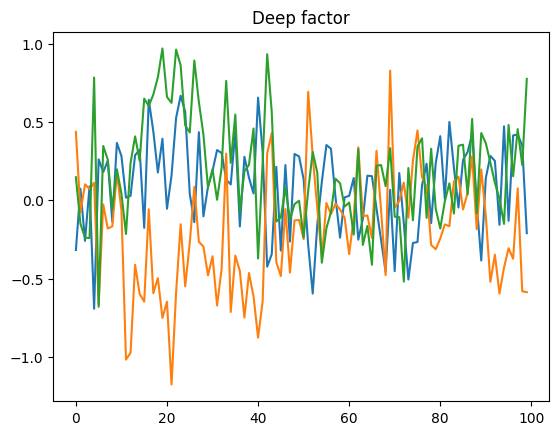

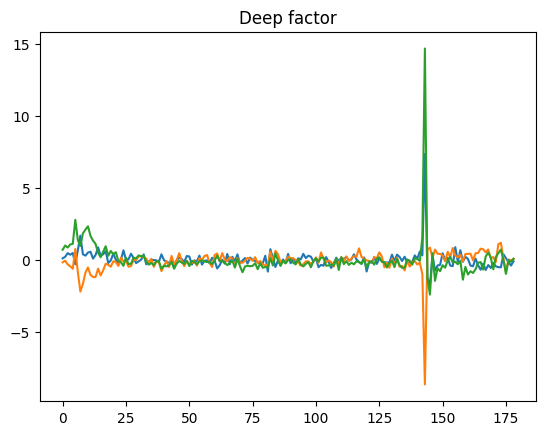

In [47]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

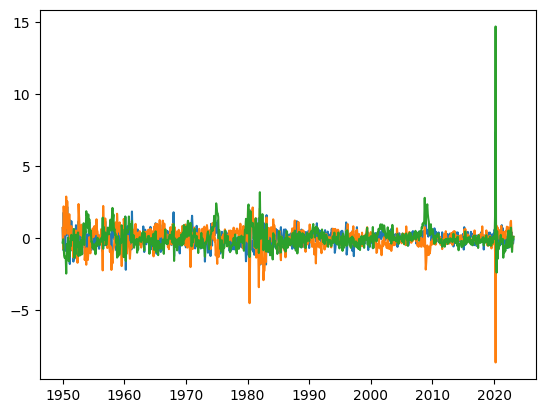

In [48]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

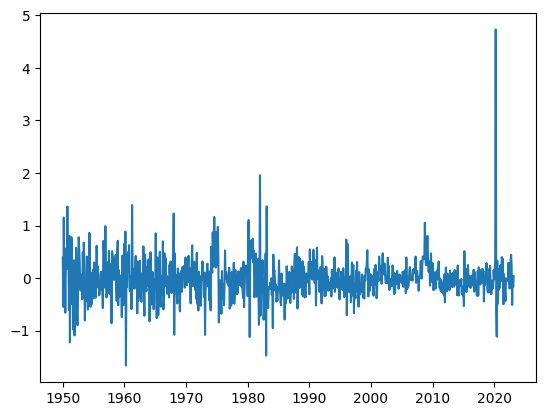

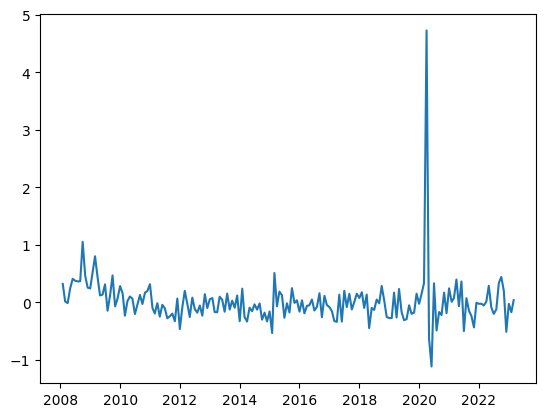

In [49]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

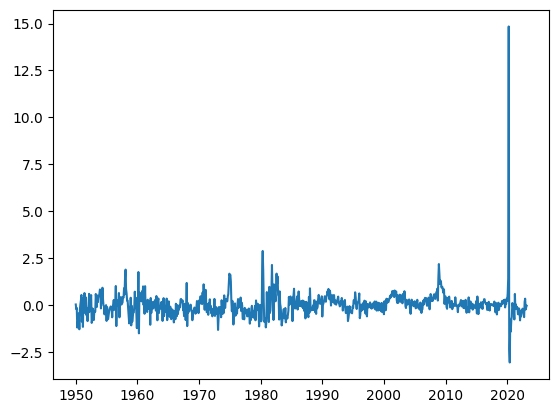

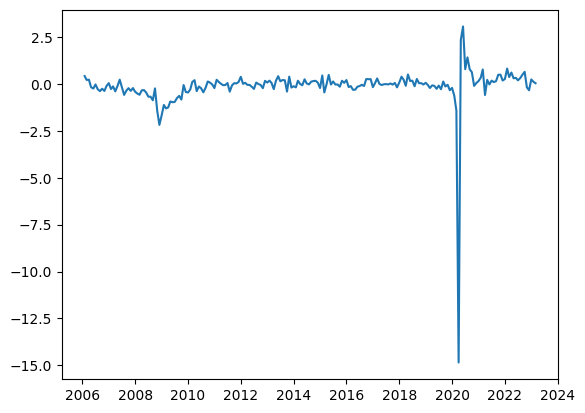

In [11]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


<Figure size 640x480 with 0 Axes>

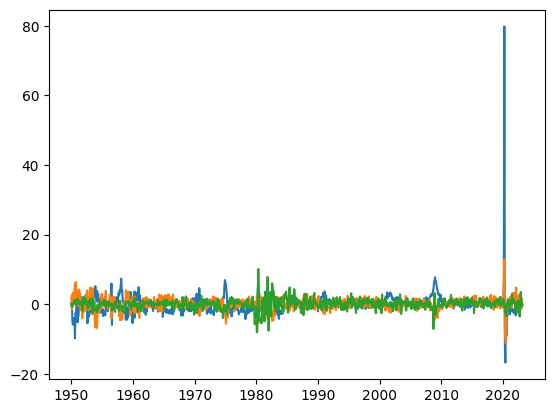

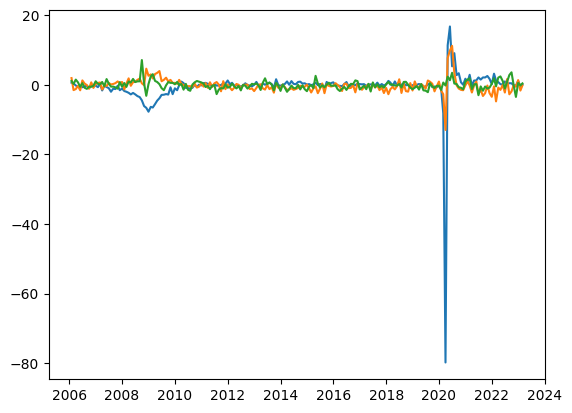

<Figure size 640x480 with 0 Axes>

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))
plt.figure()


## Cast in statespace with EKF

In [9]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = f_hat_pca[:cfg.T_train,:]
f_val_hat = f_hat_pca[cfg.T_train:cfg.T_train+cfg.T_val,:]
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
#y_hat = mod(torch.Tensor(y).float()).detach().numpy()
y_hat = pca.inverse_transform(f_train_hat)
resid = y[:cfg.T_train] - y_hat
obs_cov = np.cov(resid.T)

In [28]:
np.cov((res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:]).T)

array([[ 2.01882651, -0.67944186,  0.00239567, -0.16323359, -0.32253987],
       [-0.67944186,  1.74321139, -0.16674424,  0.40794578,  0.08130603],
       [ 0.00239567, -0.16674424,  1.97007171, -0.04088866,  0.01413676],
       [-0.16323359,  0.40794578, -0.04088866,  1.9991687 , -0.01502943],
       [-0.32253987,  0.08130603,  0.01413676, -0.01502943,  0.98406738]])

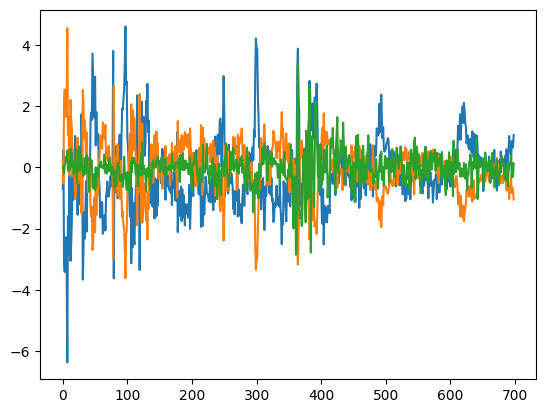

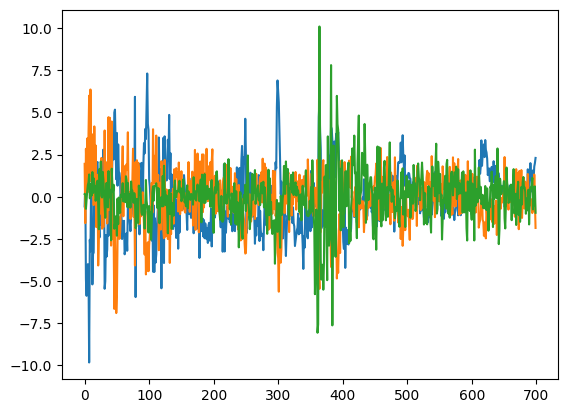

In [10]:
plt.plot(res.fittedvalues)
plt.figure()
plt.plot(np.concatenate([f_train_hat, f_val_hat]))

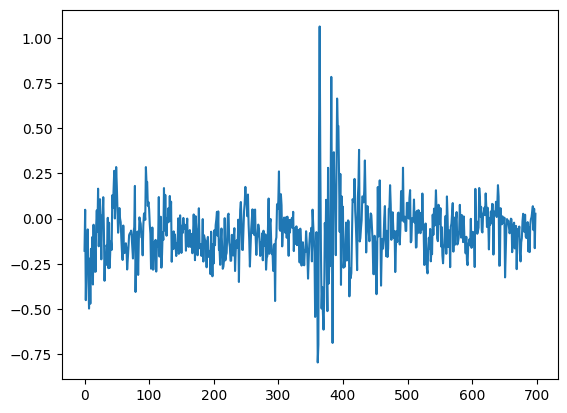

In [30]:
plt.plot(computeCI(F,res.fittedvalues))

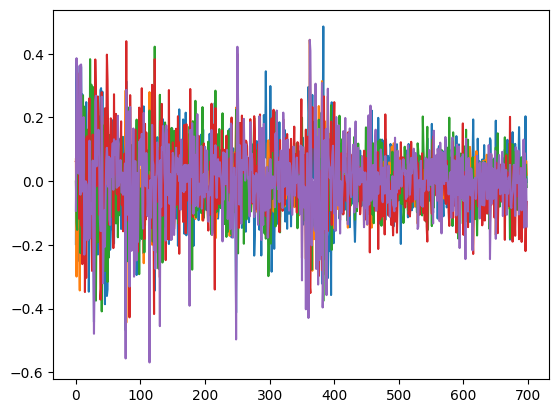

In [406]:
plt.plot(res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:])

<Axes: >

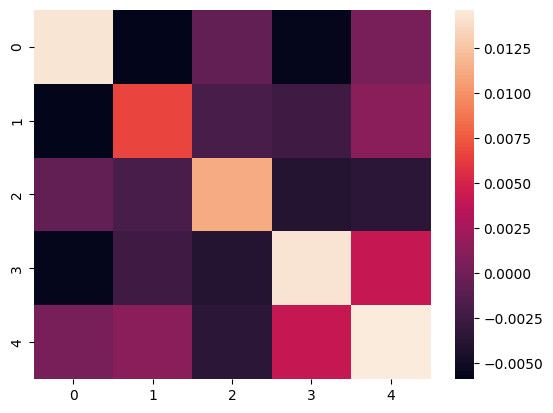

In [476]:
sns.heatmap(res.sigma_u)

<Axes: >

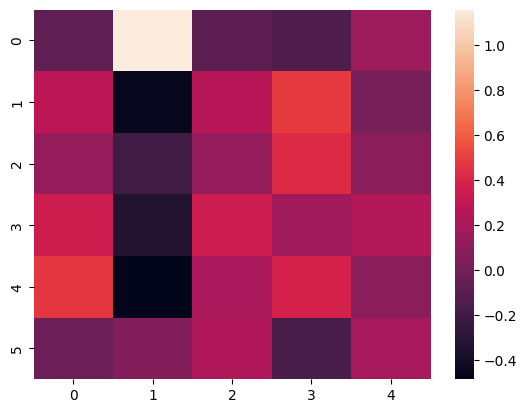

In [494]:
sns.heatmap(res.params[:])

In [498]:
res.params.T.round(3)

array([[-0.078,  0.281,  0.129,  0.347,  0.467, -0.032],
       [ 1.158, -0.46 , -0.207, -0.333, -0.486,  0.054],
       [-0.092,  0.257,  0.13 ,  0.339,  0.2  ,  0.221],
       [-0.149,  0.477,  0.417,  0.172,  0.377, -0.167],
       [ 0.155,  0.009,  0.091,  0.235,  0.083,  0.194]])

In [495]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, Jun, 2023
Time:                     13:42:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -25.4647
Nobs:                     699.000    HQIC:                  -25.5845
Log likelihood:           4038.98    FPE:                7.17800e-12
AIC:                     -25.6600    Det(Omega_mle):     6.87771e-12
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.078493         0.282644           -0.278           0.781
L1.y1         0.280757         0.166227            1.689           0.091
L1.y2         0.128641         0.244708            0.526           0.599
L1.y3         0.347430

<Axes: >

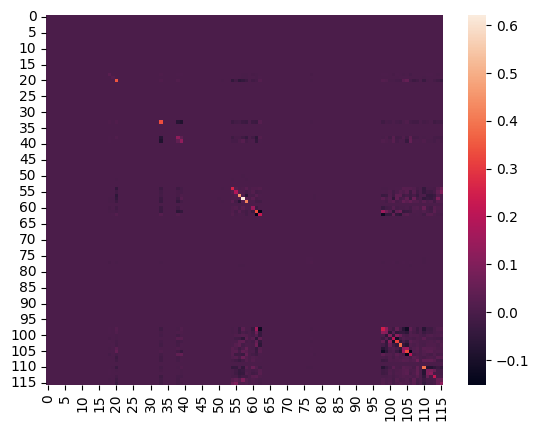

In [322]:
sns.heatmap(errorProcess.cov)

<Axes: >

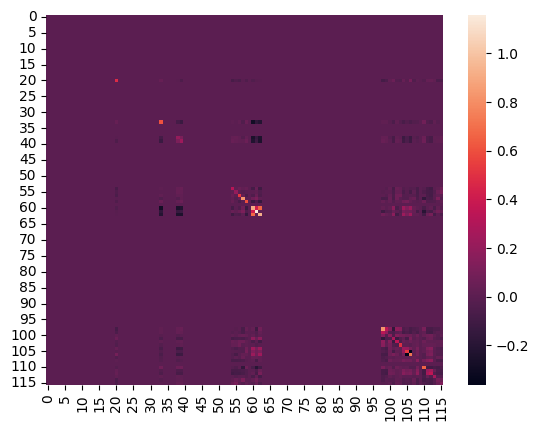

In [11]:
sns.heatmap(obs_cov)

In [46]:
from EKF.ekf import KF
y = y
Z = pca.components_.T
H = obs_cov
T = res.params[1:]
C = res.params[0]
R = np.identity(cfg.factor_dim)
Q = res.sigma_u
a0 = np.mean(f_train_hat, axis=0)
P0 = np.cov(f_train_hat.T) #None#res.sigma_u
a, P, a_filtered,v, K, F = KF(y=y,Z=Z, H=H, T=T, R=R, Q=Q, C=None, a0=a0, P0=P0)


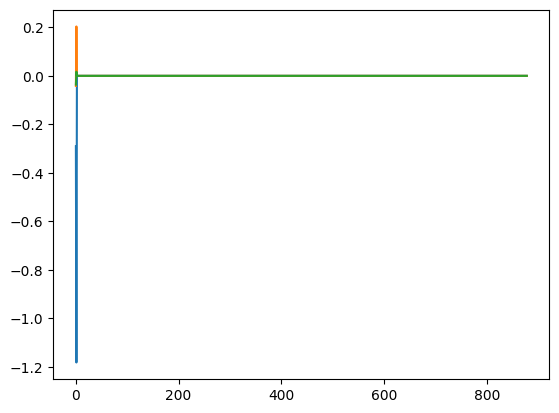

In [48]:
plt.plot(a)

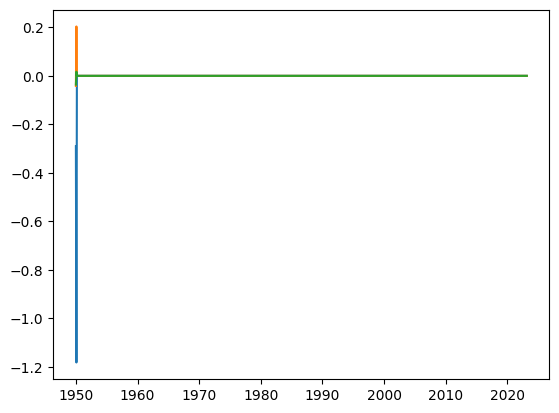

In [43]:
plt.plot(index,a[:])

NameError: name 'f_hat' is not defined

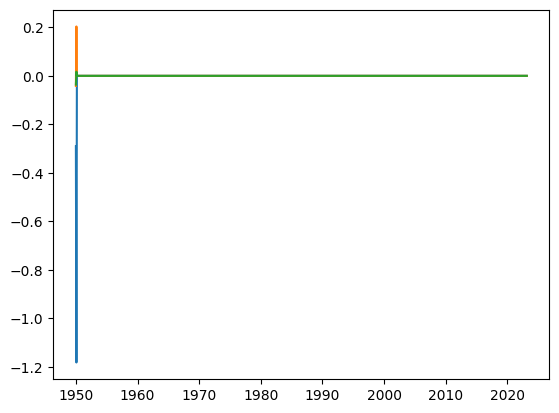

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(index,a)
plt.figure()
plt.plot(index,f_hat)

In [426]:
CI_filtered = computeCI(F, (a-a.max(axis=0)/(a.max(axis=0)-a.min(axis=0))))
plt.plot(CI_filtered)

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


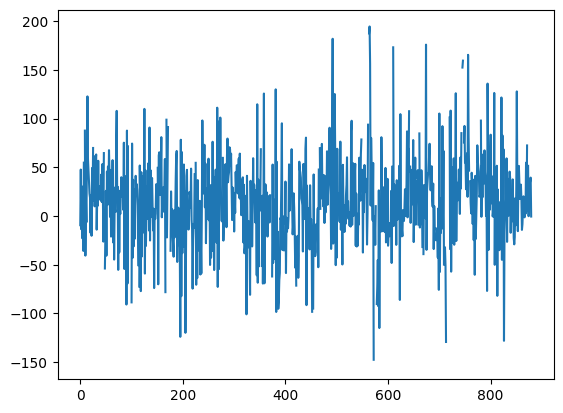

In [461]:
CI_filtered = computeCI(F, (a_smoothed-a_smoothed.max(axis=0)/(a_smoothed.max(axis=0)-a_smoothed.min(axis=0))))
plt.plot(CI_filtered)

In [190]:
res.sigma_u

array([[ 6.30185574,  4.17401048,  5.12210284,  4.03426597,  3.45850929],
       [ 4.17401048, 10.24410662,  6.82764073,  4.7609111 ,  5.24763828],
       [ 5.12210284,  6.82764073, 12.24474624,  6.3189485 ,  6.16086533],
       [ 4.03426597,  4.7609111 ,  6.3189485 , 15.63552312,  9.61933475],
       [ 3.45850929,  5.24763828,  6.16086533,  9.61933475, 14.55233607]])

In [196]:
res.mean()

array([5.87870346, 6.35967424, 6.35338814, 8.31293004, 8.66123531])

In [188]:
np.cov(f_train_hat.T).round(2)

array([[ 9.68,  7.64,  9.13, 11.03,  8.12],
       [ 7.64, 14.93, 11.67, 12.18, 10.34],
       [ 9.13, 11.67, 18.99, 15.24, 12.23],
       [11.03, 12.18, 15.24, 33.89, 21.28],
       [ 8.12, 10.34, 12.23, 21.28, 23.3 ]])

In [182]:
np.linalg.inv(np.identity(T.shape[0]**2)- np.kron(T,T)).shape

(25, 25)

In [226]:
print(unconditionalVariance(T,(res.sigma_u)).round(2))

[[-1091.19   144.89   -20.45    39.93   126.36]
 [  144.89    23.37     4.34    14.29    25.29]
 [  -20.45     4.34    12.95     4.63     2.84]
 [   39.93    14.29     4.63    21.9     21.34]
 [  126.36    25.29     2.84    21.34    43.24]]


In [154]:
res.sigma_u.shape

(5, 5)

In [74]:
np.diag(obs_cov)

array([8.16745830e-35, 6.60902332e-36, 3.99613815e-34, 3.12234067e-37,
       1.81569240e-37, 1.69090594e-40, 8.80498161e-41, 4.12026338e-40,
       1.29891480e-40, 3.94949361e-41, 9.84717543e-42, 2.41962209e-43,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.41404973e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.06585733e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.31874962e+00, 1.37078735e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.73107995e-01, 9.67830198e-01,
      

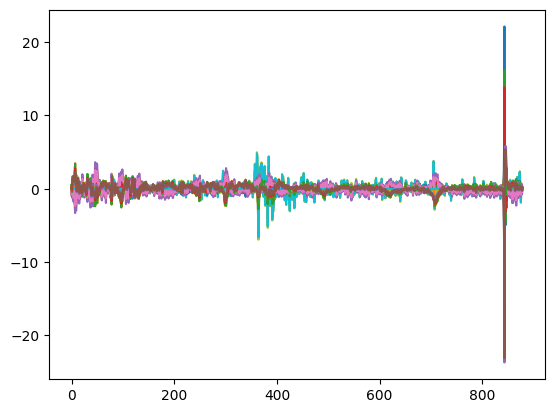

In [31]:
plt.plot([pca.components_.T @ f_hat_pca[t,:] for t in range(f_hat_pca.shape[0])]);

In [34]:
from filterpy.kalman import KalmanFilter as KalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = KalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(obs_cov))


ekf.Q = res.sigma_u
ekf.F = res.params[1:]
ekf.P = res.sigma_u
ekf.x = f_train_hat[0]
#decoder = mod.dec
ekf.H = pca.components_.T 
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.title('Filtered state')
plt.title('Filtered state')
plt.figure()
i = np.argwhere((index > '2006') & (index < '2012')).min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.title('filtered state selected period')
plt.figure()
flip = True
CI_filtered = computeCI(F, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.title('Filtered composite index selected period')
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.title('Filtered composite index whole period')
plt.figure()
plt.plot(index, np.stack(zs));


LinAlgError: Singular matrix

In [ ]:
CI_filtered = computeCI(F, f_hat_pca)


Text(0.5, 1.0, 'Filtered composite index selected period')

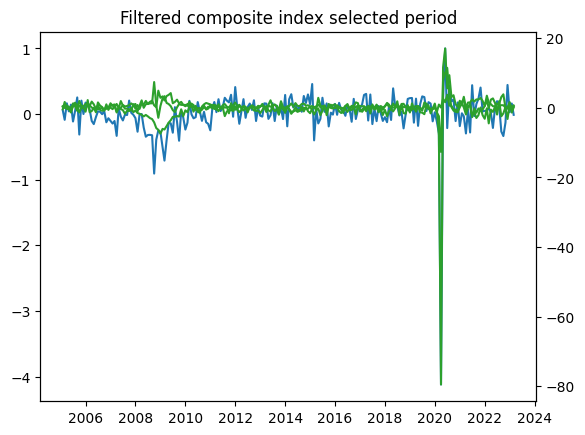

In [78]:
i = np.argwhere((index > '2005') & (index < '2012')).min()
ours = CI_filtered[i:]
ours= ours - ours.mean()
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
pca = pca-pca.mean()
plt.plot(index[i:],ours * (-1 if flip else 1))

ax = plt.twinx()
ax.plot(index[i:],pca * (-1 if flip else 1), c='C2')
plt.title('Filtered composite index selected period')

ValueError: x and y must have same first dimension, but have shapes (206,) and (218,)

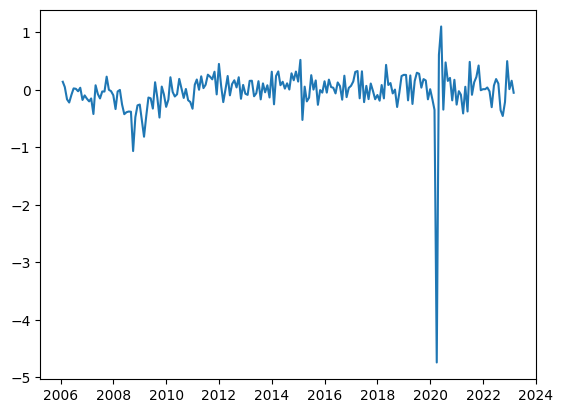

In [77]:
CI_demeaned = CI - CI.mean()
plt.plot(index[i:],CI_demeaned[i:] * (-1 if flip else 1))
plt.plot(index[i:],ours * (-1 if flip else 1))

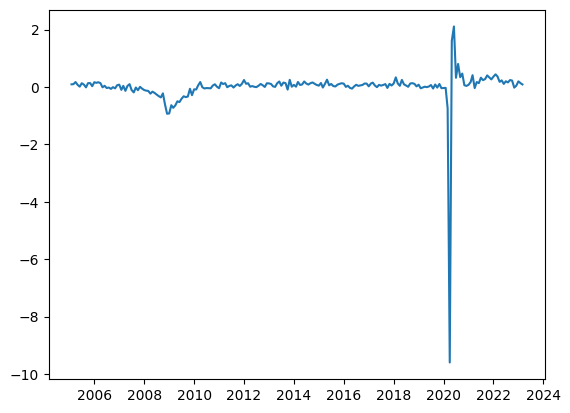

In [34]:
plt.plot(index[i:],ours * (-1 if flip else 1))

In [81]:
f_hat_pca.shape

(879, 3)

In [20]:
np.save(arr=PCA(n_components=1).fit_transform(y), file='CI_filtered_pca')

In [49]:
np.save(arr=PCA(n_components=3).fit_transform(y), file='state_filtered_pca')

In [54]:
pca  = PCA(n_components=3).fit(y[:cfg.T_train])
pred = pca.inverse_transform(pca.transform(y[cfg.T_train+cfg.T_val:]))
mse = (pred-y[cfg.T_train+cfg.T_val:])**2
np.save(arr=mse, file='mse_test_pca')

In [55]:
print(np.mean(mse))

0.34148636790136483


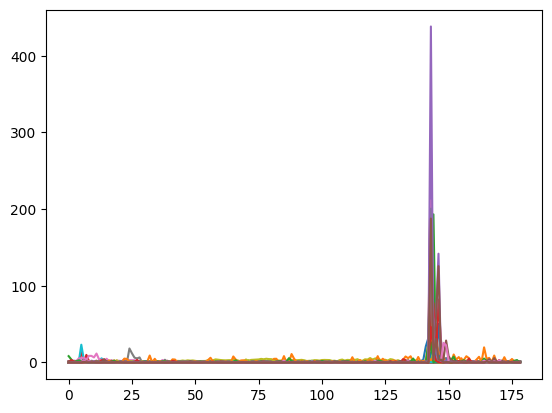

In [58]:
plt.plot(mse);

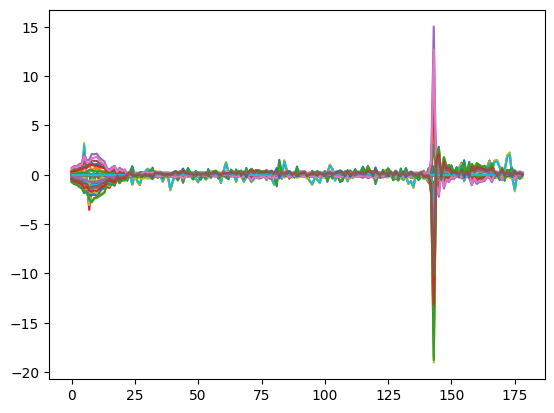

In [57]:
plt.plot(pred);